<a href="https://colab.research.google.com/github/VedereArtificiala/prelucrareaimaginilor-proiect-itzyabois/blob/main/code/final_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Choose image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
img_path = '/content/drive/MyDrive/PI/Proiect/blurry.png'
image = cv2.imread(img_path)

2. Detect

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 [==============================] - 2s 2s/step
<class 'numpy.ndarray'>
0.98427016

1/1 [==============================] - 0s 72ms/step
<class 'numpy.ndarray'>
1.0



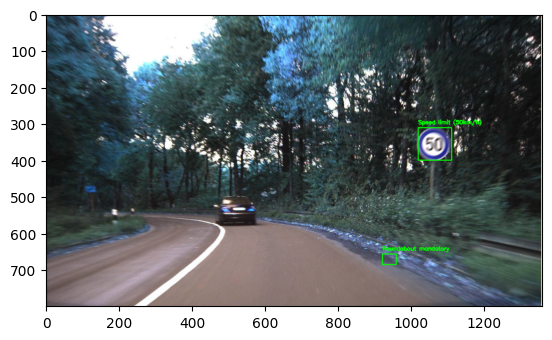

In [3]:
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.src.layers import Flatten
from skimage.feature import hog
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout


def hog_features(image):
    image = cv2.resize(image, (36, 36))

    hog_features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False,
        block_norm="L2",
        channel_axis=-1,
    )

    return hog_features


class_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons",
}


def traffic_sign_detection(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #plt.imshow("hsv", image_hsv)

    lower_red = np.array([0, 50, 50])
    upper_red = np.array([5, 255, 255])

    mask_red = cv2.inRange(image_hsv, lower_red, upper_red)

    lower_blue = np.array([102, 50, 50])
    upper_blue = np.array([104, 255, 255])

    mask_blue = cv2.inRange(image_hsv, lower_blue, upper_blue)

    mask = mask_red + mask_blue

    cv2.imwrite("masks.jpg", mask)

    cv2.imwrite("masks_red.jpg", mask_red)
    cv2.imwrite("masks_blue.jpg", mask_blue)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bboxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        aspect_ratio = w / float(h)

        area = cv2.contourArea(contour)

        if 200 < area < 500000 and 0.4 < aspect_ratio < 1.9:
            bboxes.append((x, y, w, h))

    detected_signs = []

    for contour in bboxes:
        x, y, w, h = contour

        subimage = image[y : y + h, x : x + w]

        hogf = hog_features(subimage)

        with open("/content/drive/MyDrive/PI/Proiect/svm_model.pkl", "rb") as f:
            clf = pickle.load(f)
        features = np.pad(hogf, (0, 3000 - len(hogf)), mode="constant")
        prediction = clf.predict([features])
        label = prediction[0]

        detected_signs.append(
            (x, y, x + w, y + h, label)
        )  # Store bounding box coordinates and label

    return detected_signs, image


def cnn_traffic_sign_recognition(image):
    # Preprocess image: resize, convert to grayscale, and normalize
    image = cv2.resize(image, (56, 56))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = gray_image.reshape(1, 56, 56, 1)
    model = Sequential()

    model.add(
        Conv2D(
            96,
            (5, 5),
            strides=(1, 1),
            input_shape=(56, 56, 1),
            padding="valid",
            activation="relu",
        )
    )

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(140, (3, 3), strides=(1, 1), padding="valid", activation="relu"))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(240, (3, 3), strides=(1, 1), padding="valid", activation="relu"))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(150, activation="relu"))

    model.add(Dropout(0.5))

    model.add(
        Dense(43, activation="softmax")
    )

    model.load_weights("/content/drive/MyDrive/PI/Proiect/model.h5")

    predictions = model.predict(image)
    print(type(predictions))
    return predictions


#image = cv2.imread("image.png")

signs, img = traffic_sign_detection(image)

for (x1, y1, x2, y2, label) in signs:

    detected_sign = image[y1:y2, x1:x2]

    predictions = cnn_traffic_sign_recognition(detected_sign)
    print(np.max(predictions))
    predicted_class = np.argmax(predictions)
    print()
    if np.max(predictions) >= 0:
        predicted_label = class_names[predicted_class]
        cv2.rectangle(
            image, (x1, y1), (x2, y2), (0, 255, 0), 2
        )  # Draw rectangle around the detected sign
        cv2.putText(
            image,
            f"{predicted_label}",
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2,
        )  # Add label

#cv2.imshow("Detected Signs with Predictions", img)
#cv2.imwrite("detected_signs_predictions.jpg", img)
plt.imshow(img)

#cv2.imshow("detections", img)
#cv2.imwrite("detections.jpg", img)
